In [1]:
import cv2
from torch import nn
import torch
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms
from IPython.display import Image
from matplotlib import pyplot as plt
import numpy

In [2]:
# evaluates the model on the test set
def test(model, epoch):
    means, logvars, labels, images = list(), list(), list(), list()
    test_loss = 0
    with torch.no_grad():
        model.eval()
        for x, y in bin_test_loader:
            x = x.to(device)
            # forward
            x_hat, mu, logvar = model(x)
            test_loss += loss_function(x_hat, x, mu, logvar).item()
            # log
            means.append(mu.detach())
            logvars.append(logvar.detach())
            labels.append(y.detach())
            images.append(x.detach())
    display_images(None, x_hat, f'Epoch {epoch} - Reconstructed Images', 1)
    return test_loss, means, logvars, labels, images

In [5]:
def load_model(filename):
    model = create_empty_model()
    model.load_state_dict(torch.load(filename))
    return model

In [6]:
def to_grey_scale(x):
    return numpy.asarray(x.convert("L")).astype(numpy.float64)/256.0

0.99609375, 307200


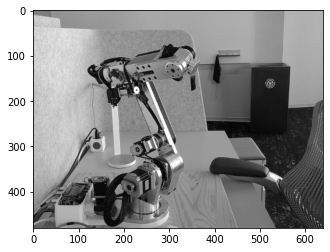

In [7]:
# Load data from images sub-folder
bin_train_loader = DataLoader(ImageFolder('images',transform=to_grey_scale))
image = bin_train_loader.dataset[0][0]
print(f"{image.max()}, {image.size}")
plt.imshow(image,cmap='gray')

0.99609375, 307200


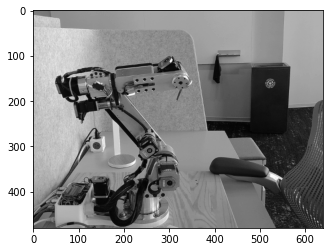

In [25]:
image = bin_train_loader.dataset[1085][0]
print(f"{image.max()}, {image.size}")
plt.imshow(image,cmap='gray')

In [12]:
model = load_model(MODEL_FILE)

0.99609375, torch.Size([480, 640]), <class 'torch.Tensor'>, torch.Size([480, 640])
1.0, 307200, <class 'numpy.ndarray'>, (480, 640)


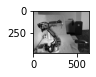

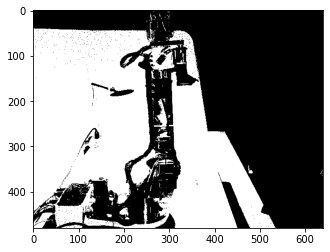

In [15]:
x_numpy = bin_train_loader.dataset[0][0]
fig = plt.figure(figsize=(1,2))
fig.add_subplot
plt.imshow(x_numpy,cmap='gray')
x = torch.from_numpy(x_numpy)
print(f"{x.max()}, {x.size()}, {type(x)}, {x.shape}")
x = x.to(device)
x_hat, mu, logvar = model(x)
im_hat = x_hat.detach().numpy()
im_hat = im_hat.reshape((480,640))
print(f"{im_hat.max()}, {im_hat.size}, {type(im_hat)}, {im_hat.shape}")
fig2 = plt.figure(2)
plt.imshow(im_hat,cmap='gray')

TypeError: Invalid shape (1, 480, 640) for image data

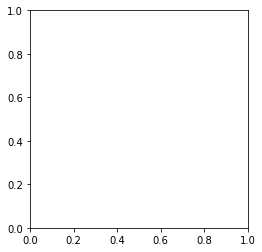